# F: Análisis de espectros: biblioteca `Specutils`

`specutils` ([documentación](https://specutils.readthedocs.io/en/stable/)) es un paquete de Python para representar, cargar, manipular y analizar datos espectroscópicos astronómicos. Los contenedores de datos genéricos y los módulos que los acompañan proporcionan una caja de herramientas que la comunidad astronómica puede usar para crear más paquetes específicos. Para installar `specutils` ejecutamos en la línea de comandos:

```
 > conda install -c conda-forge specutils
```

Como ejemplo básico, consideramos un espectro de galaxias de línea de emisión del SDSS.

Comenzamos con algunas importaciones básicas:

In [1]:
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
quantity_support()  # for getting units on the axes below  

import numpy as np
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models
from specutils import Spectrum1D, SpectralRegion

## Lectura desde un archivo

`Specutils` aprovecha la maquinaria `Astropy IO` y permite cargar y escribir en archivos. El siguiente ejemplo muestra la carga de un archivo `FITS`:

In [2]:
f = fits.open('espectros/spec-1323-52797-0012.fits')  
specdata = f[1].data 
f.close()  

Reformateamos este conjunto de datos en cantidades astronómicas y creamos un objeto ``Spectrum1D``:

In [3]:
lamb = 10**specdata['loglam'] * u.AA 
flux = specdata['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
spec = Spectrum1D(spectral_axis=lamb, flux=flux) 

Y lo graficamos:

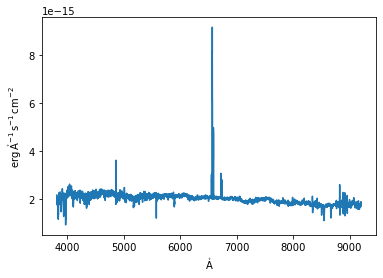

In [4]:
f, ax = plt.subplots()  
ax.step(spec.spectral_axis, spec.flux) 

## Análisis de espectros

El paquete `specutils` viene con un conjunto de herramientas para realizar tareas de análisis comunes en espectros astronómicos. A continuación se describen algunos ejemplos de la aplicación de estas herramientas. El espectro básico que se muestra aquí se usa en los ejemplos de las subsecciones siguientes: una línea de perfil gaussiano con un flujo de 5 GHz Jy.

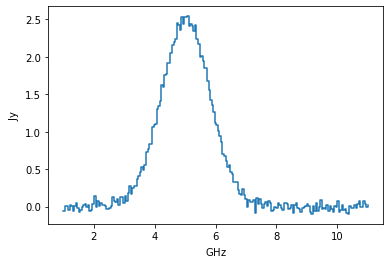

In [5]:
np.random.seed(42)
spectral_axis = np.linspace(11., 1., 200) * u.GHz
spectral_model = models.Gaussian1D(amplitude=5*(2*np.pi*0.8**2)**-0.5*u.Jy, mean=5*u.GHz, stddev=0.8*u.GHz)

flux = spectral_model(spectral_axis)
flux += np.random.normal(0., 0.05, spectral_axis.shape) * u.Jy

uncertainty = StdDevUncertainty(0.2*np.ones(flux.shape)*u.Jy)
noisy_gaussian = Spectrum1D(spectral_axis=spectral_axis, flux=flux, uncertainty=uncertainty)
import matplotlib.pyplot as plt 
plt.step(noisy_gaussian.spectral_axis, noisy_gaussian.flux) 

La relación señal-ruido de un espectro suele ser buen indicador para evaluar la calidad de un espectro. La función `snr` realiza esta tarea, ya sea en el espectro como un todo o en subregiones de un espectro:

In [6]:
from specutils.analysis import snr
snr(noisy_gaussian)  

<Quantity 2.47730666>

In [7]:
snr(noisy_gaussian, SpectralRegion(2*u.GHz, 8*u.GHz)) 

<Quantity 4.15618373>

## Búsqueda de líneas

Hay dos técnicas implementadas para encontrar líneas de emisión y/o absorción en un espectro `Spectrum1D`.

+ La primera técnica es `find_lines_threshold` que encontrará líneas mediante el umbral del flujo en función de un factor aplicado a la incertidumbre del espectro.
+ La segunda técnica es `find_lines_derivative` que encontrará las líneas basándose en el cálculo de la derivada y luego en el umbral basado en ella.

Empezamos con un espectro sintético:

In [8]:
import numpy as np
from astropy.modeling import models
import astropy.units as u
from specutils import Spectrum1D, SpectralRegion

In [9]:
np.random.seed(42)
g1 = models.Gaussian1D(1, 4.6, 0.2)
g2 = models.Gaussian1D(2.5, 5.5, 0.1)
g3 = models.Gaussian1D(-1.7, 8.2, 0.1)
x = np.linspace(0, 10, 200)
y = g1(x) + g2(x) + g3(x) + np.random.normal(0., 0.2, x.shape)
spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)

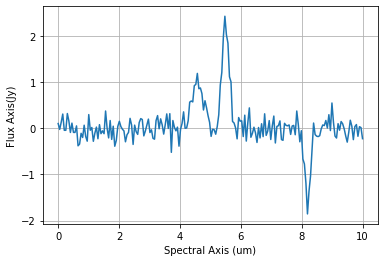

In [10]:
from matplotlib import pyplot as plt
plt.plot(spectrum.spectral_axis, spectrum.flux) 
plt.xlabel('Spectral Axis ({})'.format(spectrum.spectral_axis.unit)) 
plt.ylabel('Flux Axis({})'.format(spectrum.flux.unit)) 
plt.grid(True) 

Si bien conocemos la verdadera incertidumbre aquí, a menudo este no es el caso con datos reales. Por lo tanto, dado `find_lines_threshold` que requiere una incertidumbre, produciremos una estimación de la incertidumbre llamando a la función `noise_region_uncertainty`:

In [11]:
import warnings
from specutils.manipulation import noise_region_uncertainty

noise_region = SpectralRegion(0*u.um, 3*u.um)
spectrum = noise_region_uncertainty(spectrum, noise_region)

In [12]:
from specutils.fitting import find_lines_threshold
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    lines = find_lines_threshold(spectrum, noise_factor=3)

lines[lines['line_type'] == 'emission'] 

line_center,line_type,line_center_index
um,,
float64,str10,int64
4.572864321608041,emission,91
4.824120603015076,emission,96
5.477386934673367,emission,109
8.99497487437186,emission,179


In [13]:
lines[lines['line_type'] == 'absorption']  

line_center,line_type,line_center_index
um,,
float64,str10,int64
8.190954773869347,absorption,163


In [14]:
lines

line_center,line_type,line_center_index
um,,
float64,str10,int64
4.572864321608041,emission,91
4.824120603015076,emission,96
5.477386934673367,emission,109
8.99497487437186,emission,179
8.190954773869347,absorption,163


## Ajuste de línea

El primer paso es crear un conjunto de modelos con condiciones iniciales como parámetros. Para lograr mejores ajustes, puede ser conveniente incluir un conjunto de límites para cada parámetro, pero eso es opcional.

### Ejemplo sencillo

A continuación se muestra un ejemplo simple para demostrar cómo usar el método `fit_lines` para ajustar un espectro a una suposición inicial del modelo de Astropy.

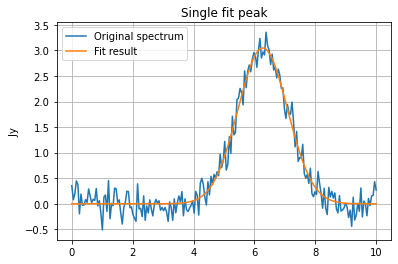

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.modeling import models
from astropy import units as u

from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines

# Create a simple spectrum with a Gaussian.
np.random.seed(0)
x = np.linspace(0., 10., 200)
y = 3 * np.exp(-0.5 * (x- 6.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)

# Fit the spectrum and calculate the fitted flux values (``y_fit``)
g_init = models.Gaussian1D(amplitude=3.*u.Jy, mean=6.1*u.um, stddev=1.*u.um)
g_fit = fit_lines(spectrum, g_init)
y_fit = g_fit(x*u.um)

# Plot the original spectrum and the fitted.
plt.plot(x, y, label="Original spectrum")
plt.plot(x, y_fit, label="Fit result")
plt.title('Single fit peak')
plt.grid(True)
plt.legend()

## Ejemplo real: galaxia SDSSCGB 56936.1

Para este ejemplo instalaremos el paquete `astroquery` que permite descargar fácilmente espectros del `SDSS`:

```
 > conda install -c astropy astroquery
```

In [16]:
from astropy import units as u
#from astropy.coordinates import SkyCoord
from astropy import coordinates as coords
ra = '12h39m38.17s'
dec = '+44d49m22.52s'
pos = coords.SkyCoord(ra, dec, frame='icrs')
pos

<SkyCoord (ICRS): (ra, dec) in deg
    (189.90904167, 44.82292222)>

In [17]:
from astroquery.sdss import SDSS

xid = SDSS.query_region(pos, spectro=True)
print(xid)

/home/zerjillo/anaconda3/envs/cursoAstronomia/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


       ra              dec        ...      specobjid       run2d 
---------------- ---------------- ... ------------------- -------
189.909048699636 44.8229242986661 ... 7470471882854080512 v5_10_0


In [18]:
specs = SDSS.get_spectra(matches=xid)

In [19]:
im = SDSS.get_images(matches=xid, band='g')
im[0].info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      96   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


In [20]:
im[0][0].header

SIMPLE  =                    T /                                                
BITPIX  =                  -32 / 32 bit floating point                          
NAXIS   =                    2                                                  
NAXIS1  =                 2048                                                  
NAXIS2  =                 1489                                                  
EXTEND  =                    T /Extensions may be present                       
BZERO   =              0.00000 /Set by MRD_SCALE                                
BSCALE  =              1.00000 /Set by MRD_SCALE                                
TAI     =        4555198318.03 / 1st row - Number of seconds since Nov 17 1858  
RA      =            190.72577 / 1st row - Right ascension of telescope boresigh
DEC     =            44.856717 / 1st row - Declination of telescope boresight (d
SPA     =              94.045  / 1st row - Camera col position angle wrt north (
IPA     =             189.55

In [21]:
from astropy.wcs import WCS
w = WCS(im[0][0].header)
x, y = w.world_to_pixel(pos)
x, y

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(array(1327.5350548), array(1224.68214133))

In [22]:
from specutils import Spectrum1D
espectro = Spectrum1D.read(specs[0], format="SDSS-III/IV spec")

In [23]:
espectro

<Spectrum1D(flux=<Quantity [-21.237778 ,   9.708488 ,   6.143837 , ...,  -1.8208474,
            -2.3184657,   8.073518 ] 1e-17 erg / (Angstrom cm2 s)>, spectral_axis=<SpectralAxis [ 3566.1538,  3566.9744,  3567.7969, ..., 10337.131 , 10339.515 ,
   10341.888 ] Angstrom>, uncertainty=InverseVariance([0.01676147, 0.0153255 , 0.01600573, ..., 0.0552746 ,
                 0.06065338, 0.05814334]))>

Text(0, 0.5, 'Flux [erg / (Angstrom cm2 s)]')

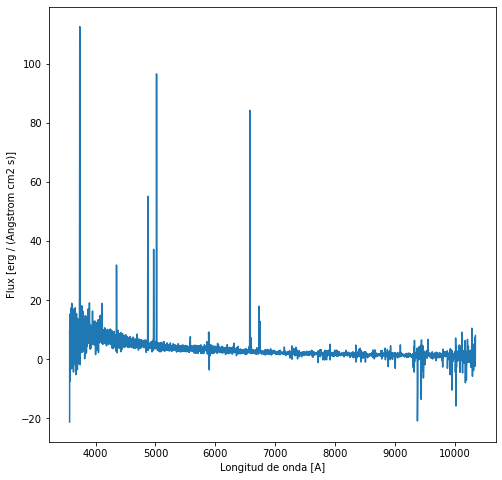

In [24]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure('Espectro', figsize=(8, 8)) 
plt.plot(espectro.spectral_axis, espectro.flux)  
plt.xlabel("Longitud de onda [A]")  
plt.ylabel("Flux [erg / (Angstrom cm2 s)]")  

Text(0, 0.5, 'pixel')

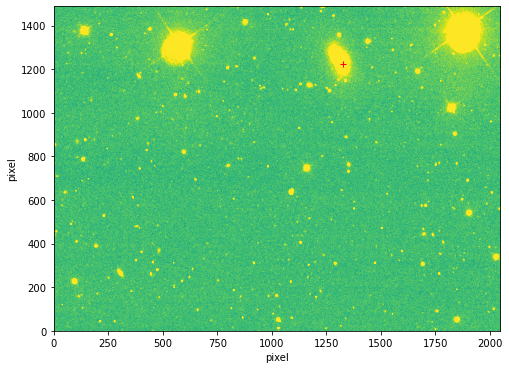

In [25]:
plt.figure('Espectro', figsize=(8, 8)) 
plt.imshow(im[0][0].data, vmin=np.min(im[0][0].data), vmax=np.mean(im[0][0].data)*2, origin='lower') 
plt.plot(x, y, color='red', marker='+')
plt.xlabel("pixel")  
plt.ylabel("pixel")  

In [26]:
import warnings
from specutils.manipulation import noise_region_uncertainty
from specutils.spectra import SpectralRegion

noise_region = SpectralRegion(7000*u.AA, 7100*u.AA)# aqui es donde yo mido el ruido
espectro = noise_region_uncertainty(espectro, noise_region)

In [27]:
from specutils.fitting import find_lines_threshold
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    lines = find_lines_threshold(espectro, noise_factor=3)

tablaEmision = lines[lines['line_type'] == 'emission'] 

In [28]:
tablaAbsorcion = lines[lines['line_type'] == 'absorption'] 

In [29]:
import pandas as pd
lineas=pd.read_csv('espectros/lines.raw', delimiter = ';')

In [30]:
lineas['linel_0'][11], lineas['valor'][11]

('[OIII]', 4363.21)

In [31]:
tablaEmision['line_center']

<Quantity [ 3569.4385,  3572.7283,  3585.0903,  3590.8735,  3597.4934,
            3602.4678,  3606.6172,  3617.4282,  3625.7686,  3631.6174,
            3635.8005,  3641.6653,  3655.9475,  3658.4734,  3671.132 ,
            3675.3608,  3694.8772,  3700.8374,  3705.1003,  3720.489 ,
            3735.9417,  3768.7732,  5017.646 ,  5893.8633,  6575.0635,
            7276.124 ,  7345.1377,  7401.1616,  7413.1006,  7606.766 ,
            7627.813 ,  7712.588 ,  7721.4717,  7751.7544,  7757.11  ,
            7821.68  ,  7827.084 ,  7914.073 ,  7992.8184,  8031.5605,
            8182.763 ,  8298.506 ,  8304.243 ,  8344.495 ,  8361.807 ,
            8398.468 ,  8417.827 ,  8435.29  ,  8460.579 ,  8493.761 ,
            8499.629 ,  8509.42  ,  8538.863 ,  8544.763 ,  8617.871 ,
            8629.788 ,  8649.68  ,  8665.626 ,  8673.612 ,  8767.988 ,
            8832.833 ,  8843.007 ,  8871.56  ,  8898.156 ,  8906.357 ,
            8924.829 ,  8931.    ,  8939.226 ,  8945.406 ,  8949.527 ,
      

In [32]:
import numpy as np 
def find_nearest(array, value): 
    array = np.asarray(array) 
    idx = (np.abs(array - value)).argmin() 
    return array[idx] 

In [33]:
find_nearest(tablaEmision['line_center'], lineas['valor'][11])

3768.7732

Text(0, 0.5, 'Flux [erg / (Angstrom cm2 s)]')

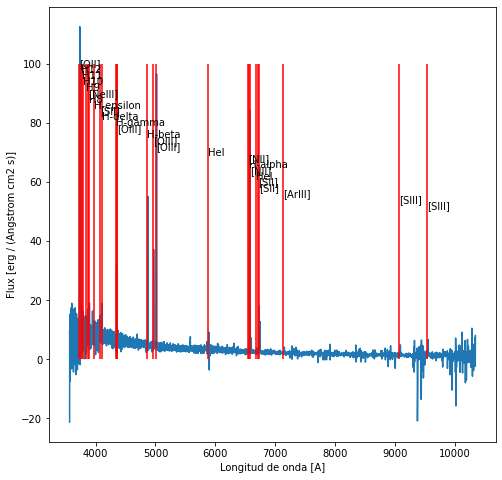

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import text
plt.figure('Espectro', figsize=(8, 8)) 
plt.plot(espectro.spectral_axis, espectro.flux)  
plt.vlines(lineas['valor'][11], ymin=0, ymax=100, color = 'r')

for i in range(len(lineas['valor'])):
    plt.vlines(lineas['valor'][i], ymin=0, ymax=100, color = 'r')
    text(lineas['valor'][i], 100-2*i, f"{lineas['linel_0'][i]}" , rotation=0, verticalalignment='center')
plt.xlabel("Longitud de onda [A]")  
plt.ylabel("Flux [erg / (Angstrom cm2 s)]")  

In [35]:
espectro_observado = []
for i in range(len(lineas['valor'])):
    espectro_observado.append(find_nearest(tablaEmision['line_center'], lineas['valor'][i]))

In [36]:
print('Espectro observado no corregido de redshift:')
for i in range(len(espectro_observado)):
    print(lineas['linel_0'][i], espectro_observado[i], lineas['valor'][i])

Espectro observado no corregido de redshift:
[OII] 3720.489 3727.42
H12 3735.9417 3750.151
H11 3768.7732 3770.63
H10 3768.7732 3797.8979999999997
H9 3768.7732 3835.384
[NeIII] 3768.7732 3869.06
H8 3768.7732 3889.0490000000004
H-epsilon 3768.7732 3970.072
[SII] 3768.7732 4072.5
H-delta 3768.7732 4101.734
H-gamma 3768.7732 4340.464
[OIII] 3768.7732 4363.21
H-beta 5017.646 4861.325
[OIII] 5017.646 4958.911
[OIII] 5017.646 5006.843
HeI 5893.8633 5875.97
[NII] 6575.0635 6548.04
H-alpha 6575.0635 6562.8
[NII] 6575.0635 6583.46
HeI 6575.0635 6678.15
[SII] 6575.0635 6716.44
[SII] 6575.0635 6730.81
[ArIII] 7276.124 7135.8
[SIII] 9088.661 9068.6
[SIII] 9523.576 9530.6


La correccion de redshift se haría como:
$$ z= \frac{\lambda_{observado}-\lambda_{emitida}}{\lambda_{emitida}}$$

Por lo tanto la correccion de redshift es:

In [37]:
z = (lineas['valor'][0]-espectro_observado[0])/espectro_observado[0]
z

0.0018629234766331566